# Определение стоимости автомобилей

**Описание проекта:**  

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки качества моделей будем применять метрику RMSE.

**Описание данных**  

Данные находятся в файле /datasets/autos.csv.

**Признаки**  

DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля   
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

**Целевой признак**  

Price — цена (евро)


## Подготовка данных

Импортируем все необходимые библиотеки и структуры. Загрузим и изучим данные.

In [1]:
pip install optuna

     |████████████████████████████████| 348 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 42.2 MB 27 kB/s s eta 0:00:01
     |████████████████████████████████| 80 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 147 kB 97.9 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 112 kB 63.3 MB/s eta 0:00:01
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11107 sha256=b69fe869e746c752b3be3871b055fe8ee77a4c5d9ad25d5d650d5921e16c0bf6
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.1
    Uninstalling scipy-1.9.1:
      Successfully uninstalled scipy-1.9.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U fast_ml

     |████████████████████████████████| 42 kB 584 kB/s eta 0:00:01


In [3]:
!pip install lightgbm

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import seaborn as sns
import matplotlib.pyplot as plt
from fast_ml.model_development import train_valid_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder

In [5]:
autos = pd.read_csv('/datasets/autos.csv')

In [6]:
print('Общая информация о данных')
print()
autos.info()
print()
print('Числовое описание данных')
print(autos.describe())
print()
print('Наличие пропусков')
print(autos.isnull().sum())
print()
print('Наличие дубликатов')
print(autos.duplicated().sum())
print()
print('Представление данных')
display(autos)

Общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  objec

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Выполним предобработку данных.

In [7]:
autos.columns = autos.columns.str.lower()

In [8]:
autos.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Перейдем к дубликатам, посмотрим на них и решим стоит ли их удалять.

In [9]:
duplicated_autos = autos.drop(['datecrawled', 'datecreated', 'lastseen', 
                               'registrationmonth', 'gearbox', 'notrepaired', 'numberofpictures'], axis=1)
duplicated_autos[duplicated_autos.duplicated()].head()

,price,vehicletype,registrationyear,power,model,kilometer,fueltype,brand,postalcode
1017,500,small,1996,45,corsa,70000,petrol,opel,8496
1051,11890,bus,2011,116,c_max,150000,gasoline,ford,97737
2169,0,coupe,2002,129,c_klasse,150000,petrol,mercedes_benz,33813
3551,1670,sedan,1999,75,golf,150000,petrol,volkswagen,52388
3786,2999,sedan,2002,101,golf,150000,gasoline,volkswagen,32756


Не понятно почему duplicated() выдает наличие 4 дубликатов, визуально данные в этих строках трудно назвать дубликатами. Оставим как есть.

Приведем даты к формату datetime. Позже выяснилось, что даты совсем не пригодились в проекте, кроме того как посмотреть период публикации объявлений.

In [10]:
autos['datecrawled'] = pd.to_datetime(autos['datecrawled'], format='%Y-%m-%dT%H:%M:%S')
autos['lastseen'] = pd.to_datetime(autos['lastseen'], format='%Y-%m-%dT%H:%M:%S')
autos['datecreated'] = pd.to_datetime(autos['datecreated'], format='%Y-%m-%dT%H:%M:%S')

Перейдем к пропущенным значениям

In [11]:
autos['notrepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [12]:
autos['notrepaired'] = autos['notrepaired'].fillna('unknown')

Заполнили пропуски в 'notrepaired' значением 'unknown', поскольку достоверное нельзя сказать был автомобиль в ремонте или нет.

In [13]:
autos['model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [14]:
autos['model'] = autos['model'].fillna('other') 

Заполнили пропуски в 'model' значением 'other', поскольку такое значение уже есть в списке.

In [15]:
autos['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
autos['gearbox'] = autos['gearbox'].fillna('unknown')

Заполнили пропуски в 'gearbox' значением 'unknown'.

In [17]:
autos['vehicletype'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [18]:
autos['vehicletype'] = autos['vehicletype'].fillna(autos['vehicletype'].mode().values[0])

Заполнили пропуски 'vehicletype' модой.

In [19]:
autos['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [20]:
autos['fueltype'] = autos['fueltype'].fillna(autos['fueltype'].mode().values[0])

Заполнили пропуски 'fueltype' модой.

In [21]:
autos.corr()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
registrationyear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
registrationmonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
numberofpictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalcode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Text(0.5, 1.0, 'Треугольная тепловая карта корреляции')

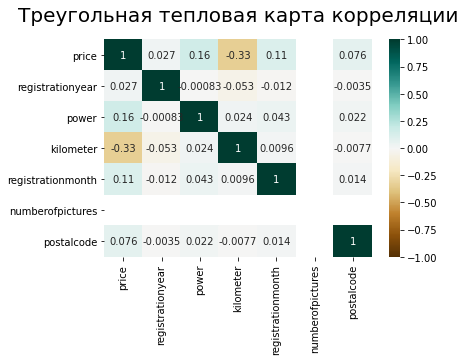

In [22]:
heatmap = sns.heatmap(autos.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Треугольная тепловая карта корреляции', fontdict={'fontsize':20}, pad=18)

Посмотрим на распределение данных.

<AxesSubplot:>

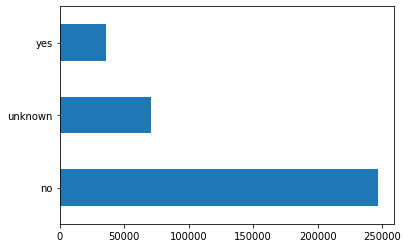

In [23]:
autos['notrepaired'].value_counts().plot(kind='barh')

<AxesSubplot:>

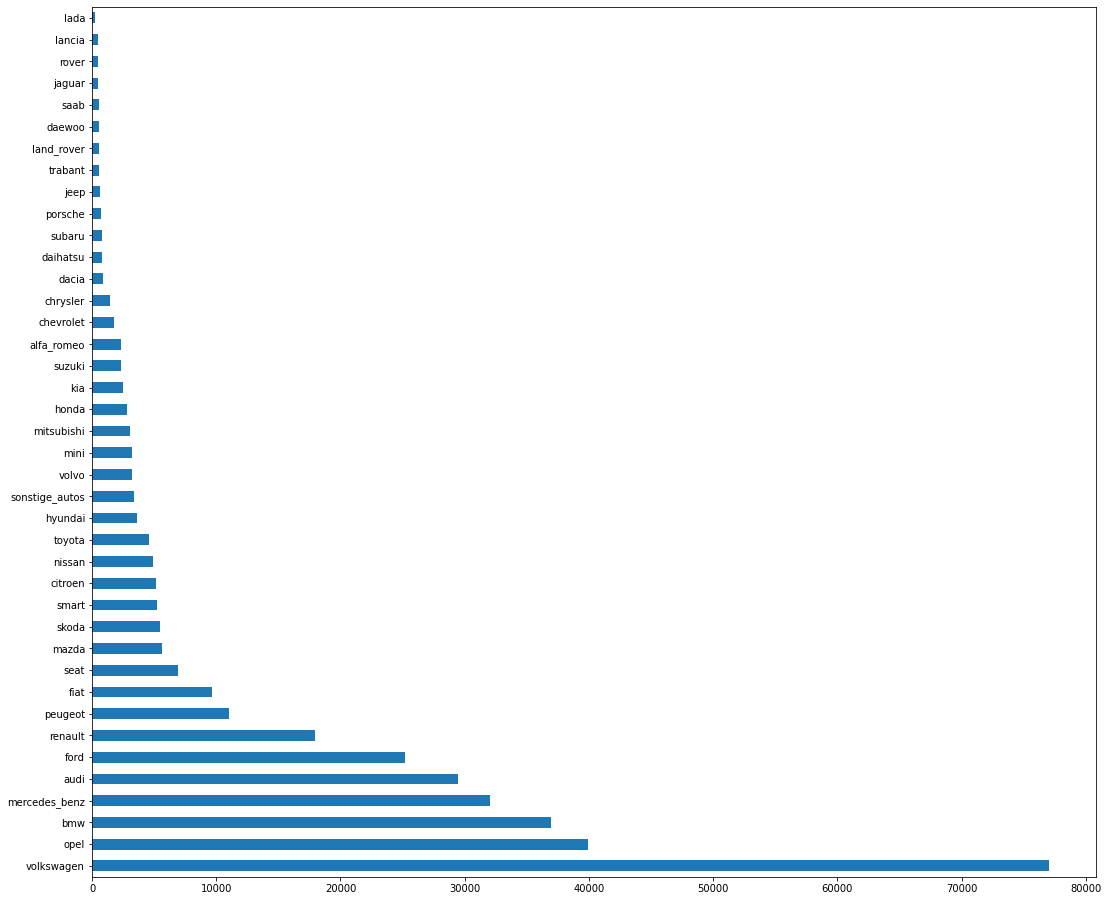

In [24]:
autos['brand'].value_counts().plot(kind='barh',figsize=(18,16))

<AxesSubplot:>

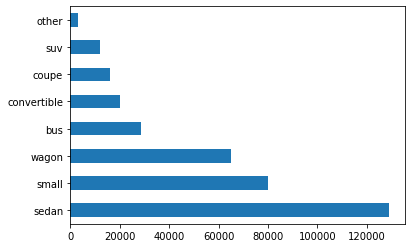

In [25]:
autos['vehicletype'].value_counts().plot(kind='barh')

<AxesSubplot:>

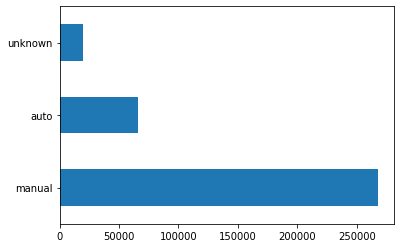

In [26]:
autos['gearbox'].value_counts().plot(kind='barh')

<AxesSubplot:>

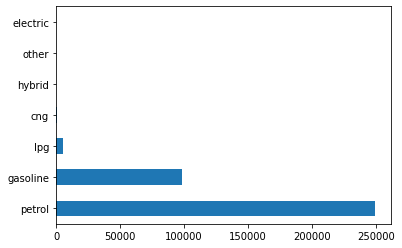

In [27]:
autos['fueltype'].value_counts().plot(kind='barh')

In [28]:
autos['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000,   5000, 100000,
        60000,  20000,  80000,  50000,  10000])

In [29]:
autos.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

<AxesSubplot:xlabel='price'>

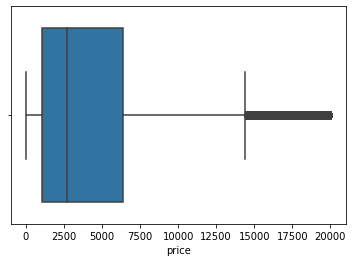

In [30]:
sns.boxplot(x=autos['price'])

В столбце 'price' есть нулевые значения, а также значения до 100. Думаю, что замена нулей на медиану, не решает вопрос с аномалиями. Возможно это значения указаны в неверных единицах измерения. Например, 3,0 это 3000 и т.д. Оставим все как есть.

In [31]:
autos = autos.query('price > 100')

In [32]:
autos['fueltype'].unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

<AxesSubplot:>

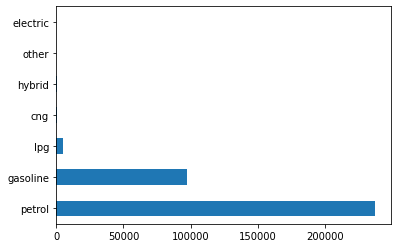

In [33]:
autos['fueltype'].value_counts().plot(kind='barh')

<AxesSubplot:xlabel='registrationyear'>

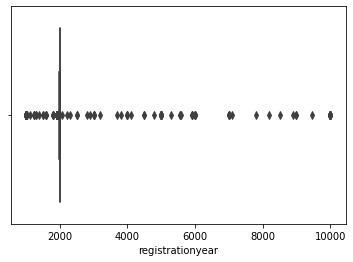

In [34]:
sns.boxplot(x=autos['registrationyear'])

В 'registrationyear' есть аномальные значения, например 1111 год регистрации автомобиля или 3500. Заполним аномальные значения приближенными к реальности, т.е. от 1960 до 2016 года. 

In [35]:
autos['registrationyear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       5600, 1600, 1111, 1039, 1300, 2800, 1931, 4500, 1602, 7800, 1947,
       1927, 7100, 8200, 1946])

In [36]:
def real_registration_year(year):
    if year > 2016:
        return 2016
    elif year < 1960:
        return 1960
    else:
        return year
autos['registrationyear'] = autos['registrationyear'].apply(real_registration_year)

<AxesSubplot:xlabel='registrationyear'>

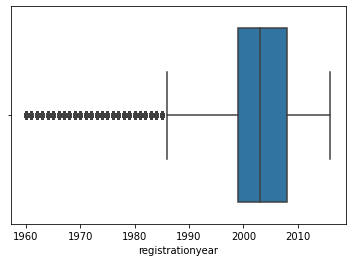

In [37]:
sns.boxplot(x=autos['registrationyear'])

In [38]:
autos['registrationmonth'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

In [39]:
autos['kilometer'].unique()

array([150000, 125000,  90000,  30000,  70000,   5000, 100000,  60000,
        20000,  80000,  50000,  40000,  10000])

In [40]:
autos.query('power == 6920')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
33952,2016-03-09 11:37:03,3740,small,2006,manual,6920,aygo,90000,10,petrol,toyota,no,2016-03-09,0,94116,2016-03-17 05:16:32


In [41]:
autos['power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    90,
          50,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         232,   150,   156,    82,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   286,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   280,   260,   104,   188,   333,   186,   117,   141,
          59,   132,   234,   158,    39,    92,    51,   135,   230,
         209,    43,

In [42]:
def real_power(power):
    if power > 2000:
        return 2000
    elif power < 40:
        return 40
    else:
        return power
autos['power'] = autos['power'].apply(real_power)

In [43]:
autos = autos.drop(['numberofpictures', 'postalcode', 'datecrawled', 'datecreated', 'lastseen', 'registrationmonth'], axis=1)

In [44]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340024 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             340024 non-null  int64 
 1   vehicletype       340024 non-null  object
 2   registrationyear  340024 non-null  int64 
 3   gearbox           340024 non-null  object
 4   power             340024 non-null  int64 
 5   model             340024 non-null  object
 6   kilometer         340024 non-null  int64 
 7   fueltype          340024 non-null  object
 8   brand             340024 non-null  object
 9   notrepaired       340024 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.5+ MB


**Вывод по 1 шагу**

На первом шаге произведена загрузка данных и их подготовка для обучения моделей. 

1. Перед нами DataFrame в из 16 столбцов с данными и 354369 строк, содержащий информацию о технических особенностях и ценах автомобилей, размещенных в сервисе «Не бит, не крашен».
2. Заполнены пропуски в столбцах 'vehicletype', 'gearbox', 'model', 'fueltype', 'notrepaired'.
3. Проведена работа с аномальными значениями в 'price','registrationyear' и 'power'.
4. Удалены ненужные столбцы для обучения моделей, а именно - 'numberofpictures', 'postalcode', 'datecrawled', 'datecreated', 'lastseen' и 'registrationmonth'.

Для того, чтобы в реальной жизни не случались такие ситуации с огромным количеством пропусков и аномальных значений, необходимо анализировать информацию, обсуждать ее с командой проекта и улучшать сервис (например, ввести ограничения по вводу года выпуска или обязательное заполнение полей).

DataFrame готов, можно перейти к обучению моделей.

## Обучение моделей

Подготовим выборки для обучения LinearRegression. Проведем масштабирование признаков с помощью get_dummies.

In [45]:
autos_ohe = autos.copy()
autos_ohe = pd.get_dummies(autos_ohe)

Разделим датасет на features_train, features_valid, target_train, target_valid. Сделаем проверку методом shape.

In [46]:
features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe, features_test_ohe, target_test_ohe = train_valid_test_split(
    autos_ohe, target='price', train_size=0.60, valid_size=0.2, test_size=0.2)

In [47]:
print(features_train_ohe.shape, target_train_ohe.shape)
print(features_valid_ohe.shape, target_valid_ohe.shape)
print(features_test_ohe.shape, target_test_ohe.shape)

(204014, 314) (204014,)
(68005, 314) (68005,)
(68005, 314) (68005,)


Подготовим выборки для обучения моделей основанных на деревьях решений. 
Проведем порядковое кодирование с помощью OrdinalEncoder().

In [48]:
encoder = OrdinalEncoder()

In [49]:
category = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [50]:
data_ordinal = autos.copy()
encoder.fit(autos[category])
data_ordinal[category] = encoder.transform(autos[category])

In [52]:
target = data_ordinal['price']
features = data_ordinal.drop('price', axis=1)

In [53]:
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_split(
    data_ordinal, target='price', train_size=0.60, valid_size=0.2, test_size=0.2)

In [54]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(204014, 9) (204014,)
(68005, 9) (68005,)
(68005, 9) (68005,)


Обучим следующие модели:

LinearRegression  
RandomForestRegressor  
LightGBM  
CatBoostRegressor  

Для каждой модели попробуем разные гиперпараметры.

In [55]:
def RMSE(target, predict):
    RMSE = (mean_squared_error(target, predict))**0.5
    return RMSE

score = make_scorer(RMSE, greater_is_better=False)

Напишем функцию для LinearRegression, которая будет принимать на вход features_train, target_train, features_valid, target_valid, а возвращать значение MSE, RMSE и предсказания на валидационной выборке.

In [56]:
model = LinearRegression()

def lr_model_rmse(features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    model.score(features_valid, target_valid)
    print("MSE =", round(mse,2))
    print("RMSE =", round(mse ** 0.5, 2))
    return predicted_valid

In [57]:
%%time
linear_model = lr_model_rmse(features_train_ohe, target_train_ohe, features_valid_ohe, target_valid_ohe)

MSE = 8071297.14
RMSE = 2841.0
CPU times: user 11.7 s, sys: 8.92 s, total: 20.6 s
Wall time: 20.7 s


Перейдем к обучению RandomForestRegressor

In [58]:
%%time

forest_model = RandomForestRegressor(random_state=12345) 
forest_parametrs = { 'n_estimators': range(5, 20),
                     'max_depth': range(1, 5)}
grid = GridSearchCV(forest_model, forest_parametrs, cv=3)
grid.fit(features_train, target_train) 
predictions_valid = grid.predict(features_valid)
result = mean_squared_error(target_valid, predictions_valid)**0.5 
print("RMSE наилучшей модели на валидационной выборке:", round(result,2))

RMSE наилучшей модели на валидационной выборке: 2645.25
CPU times: user 1min 45s, sys: 113 ms, total: 1min 45s
Wall time: 1min 45s


In [59]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 19}

Перейдем к CatBoost.
При обучении модели CatBoost можно визуализировать, установив plot=true.

In [60]:
cat = CatBoostRegressor()

In [61]:
%%time
cat.fit(features_train, target_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 25.1 s, sys: 145 ms, total: 25.2 s
Wall time: 26.8 s


Также выполним кроссвалидацию и визуализируем процесс.

In [62]:
params = {"iterations": 150,
          "depth": 2,
          "loss_function": "RMSE",
          "verbose": False}
cv_dataset = Pool(data=features_train,
                  label=target_train)
scores = cv(cv_dataset,
            params,
            fold_count=2, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/2]

bestTest = 2436.109507
bestIteration = 149

Training on fold [1/2]

bestTest = 2459.314623
bestIteration = 149



In [63]:
%%time
predict_cat = cat.predict(features_valid)
rmse_cat = mean_squared_error(target_valid, predict_cat)**0.5
print('RMSE CatBoostRegressor:', round(rmse_cat,2))

RMSE CatBoostRegressor: 1654.15
CPU times: user 62.4 ms, sys: 3.73 ms, total: 66.1 ms
Wall time: 65.7 ms


Перейдем к LightGBM.

In [64]:
%%time
model = LGBMRegressor(random_state=42)
model.fit(features_train, target_train)
predict_lgb = model.predict(features_valid)
rmse_lgb = mean_squared_error(target_valid, predict_lgb)**0.5
print('RMSE LGBMRegressor:', round(rmse_lgb, 2))

RMSE LGBMRegressor: 1750.94
CPU times: user 7min 42s, sys: 3.21 s, total: 7min 45s
Wall time: 7min 48s


Проведено обучение моделей: LinearRegression, RandomForestRegressor, LightGBM и CatBoostRegressor. 
Наилучшее время обучения у 
LightGBM, а наименьшее RMSE у CatBoostRegressor.

## Анализ моделей

Проанализируем время обучения моделей, время предсказания и качество моделей.
Выберем лучшую модель, опираясь на качество, полученное на валидационной выборке.

In [65]:
%%time
const_model = DummyRegressor(strategy="mean")
const_model.fit(features_train, target_train)

CPU times: user 1.44 ms, sys: 33 µs, total: 1.48 ms
Wall time: 829 µs


DummyRegressor()

In [66]:
%%time
predicted_const_model = const_model.predict(features_valid)
RMSE_const_model = mean_squared_error(target_valid, predicted_const_model)**0.5 
print('RMSE константной модели на валидационной выборке:', RMSE_const_model)

RMSE константной модели на валидационной выборке: 4522.736739565117
CPU times: user 0 ns, sys: 2.07 ms, total: 2.07 ms
Wall time: 1.77 ms


In [67]:
%%time
linear_model_valid = LinearRegression()
linear_model_valid.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.4 s, sys: 10.1 s, total: 22.5 s
Wall time: 22.5 s


LinearRegression()

In [68]:
%%time
predicted_linear_model_valid = linear_model_valid.predict(features_valid_ohe)
RMSE_linear_model_valid = mean_squared_error(target_valid_ohe, predicted_linear_model_valid)**0.5 
print('RMSE LinearRegression на валидационной выборке:', round(RMSE_linear_model_valid,2))

RMSE LinearRegression на валидационной выборке: 2841.0
CPU times: user 175 ms, sys: 130 ms, total: 305 ms
Wall time: 297 ms


In [69]:
%%time
forest_model = RandomForestRegressor(max_depth=4, n_estimators=19, random_state=42)
forest_model.fit(features_train, target_train)

CPU times: user 1.9 s, sys: 47.9 ms, total: 1.95 s
Wall time: 2.01 s


RandomForestRegressor(max_depth=4, n_estimators=18, random_state=42)

In [70]:
%%time
predicted_forest_model = forest_model.predict(features_valid)
RMSE_forest_model = mean_squared_error(target_valid, predicted_forest_model)**0.5 
print('RMSE RandomForestRegressor на валидационной выборке:', round(RMSE_forest_model,2))

RMSE RandomForestRegressor на валидационной выборке: 2664.78
CPU times: user 43.2 ms, sys: 1e+03 ns, total: 43.2 ms
Wall time: 41.2 ms


In [71]:
%%time
cat_model = CatBoostRegressor()
cat_model.fit(features_train, target_train, verbose=False)

CPU times: user 24.2 s, sys: 106 ms, total: 24.3 s
Wall time: 25.2 s


In [72]:
%%time
predict_cat = cat_model.predict(features_valid)
RMSE_cat = mean_squared_error(target_valid, predict_cat)**0.5
print('RMSE CatBoostRegressor на валидационной выборке:', round(RMSE_cat,2))

RMSE CatBoostRegressor на валидационной выборке: 1654.15
CPU times: user 62.8 ms, sys: 143 µs, total: 62.9 ms
Wall time: 61.4 ms


In [73]:
%%time
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(features_train, target_train)

CPU times: user 39.7 s, sys: 286 ms, total: 40 s
Wall time: 40.5 s


LGBMRegressor(random_state=42)

In [74]:
%%time
predict_lgb_model = lgb_model.predict(features_valid)
mse = mean_squared_error(target_valid, predict_lgb_model)
RMSE_lgb_model = mean_squared_error(target_valid, predict_lgb_model)**0.5 
print('RMSE LGBMRegressor на валидационной выборке:', round(RMSE_lgb_model,2))

RMSE LGBMRegressor на валидационной выборке: 1750.94
CPU times: user 485 ms, sys: 0 ns, total: 485 ms
Wall time: 498 ms


Создадим итоговую таблицу для наглядности полученных результатов.

In [77]:
columns = ['Название модели', 'Время обучения модели, s.', 'Время предсказания модели, ms.','RMSE']
const_model = ['DummyRegressor', 0 , 1.77, round(RMSE_const_model,2)]
linear_model = ['LinearRegression', 22.5, 297, round(RMSE_linear_model_valid,2)]
forest_model = ['RandomForestRegressor', 2.01, 41.2, round(RMSE_forest_model,2)]
cat_model = ['CatBoostRegressor', 25.2, 61.4, round(RMSE_cat,2)]
lgb_model = ['LightGBM', 40.5, 498, round(RMSE_lgb_model,2)]

table = pd.DataFrame([const_model, linear_model, forest_model, cat_model, lgb_model], columns = columns)
print('RMSE моделей')
display(table)

RMSE моделей


,Название модели,"Время обучения модели, s.","Время предсказания модели, ms.",RMSE
0,DummyRegressor,0.00,1.77,4522.74
1,LinearRegression,22.50,297.00,2841.00
2,RandomForestRegressor,2.01,41.20,2664.78
3,CatBoostRegressor,25.20,61.40,1654.15
4,LightGBM,40.50,498.00,1750.94


# Тестирование лучшей модели

In [76]:
%%time
cat_model_test = CatBoostRegressor()
cat_model_test.fit(features_train, target_train, verbose=False)
predict_cat_test = cat_model_test.predict(features_test)
RMSE_cat_test = mean_squared_error(target_test, predict_cat_test)**0.5
print('RMSE CatBoostRegressor на тестовой выборке:', round(RMSE_cat_test,2))

RMSE CatBoostRegressor на тестовой выборке: 1666.62
CPU times: user 24.3 s, sys: 153 ms, total: 24.4 s
Wall time: 25.4 s


**Общий вывод**

На первом шаге произведена загрузка данных и их подготовка для обучения моделей. Заполнены пропуски, проведена работа с аномальными значениями. Удалены ненужные столбцы для обучения моделей.

На втором шаге проведено обучение моделей: LinearRegression, RandomForestRegressor, LightGBM и CatBoostRegressor.

На третьем шаге проведена проверка модели на адекватность, оценка RMSE на тестовой выборке и определено время обучения.
Наименьший показатель RMSE у CatBoostRegressor (1654,15), время обучения 25.2 s, а время предсказания 61.4 ms. 
На втором месте - LightGBM, RMSE составил 1750.94, время обучения 40.5 s, время предсказания 498 ms.

С учетом полученных результатов и требованием заказчика, 
рекомендовано использовать **CatBoostRegressor**.